In [1]:
import numpy as np
#image handling
import PIL.Image as Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import datetime
import time
# for the evaluation
%load_ext tensorboard

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
 
from sklearn.metrics import classification_report, confusion_matrix
 
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
 
import cv2
 
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold

In [2]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from PIL import Image
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import warnings
import os
import shutil
from PIL import ImageFile
warnings.simplefilter('error', Image.DecompressionBombWarning)
ImageFile.LOAD_TRUNCATED_IMAGES = True
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [10]:
root_path='C:/Users/WeixiLi/Desktop/Broccoli'

datasetFolderName=root_path
MODEL_FILENAME=root_path+"/model_kfold_cv.h5"
sourceFiles=[]
classLabels=['1', '2', '3', '4']
X=[]
Y=[]

img_rows, img_cols =  240, 320 # input image dimensions
train_path=datasetFolderName+'/train/'
validation_path=datasetFolderName+'/validation/'
test_path=datasetFolderName+'/test/'

In [4]:
def transferBetweenFolders(source, dest, splitRate): 
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(datasetFolderName+'/'+source+'/'+label+'/', 
                               datasetFolderName+'/'+dest+'/'+label+'/', 
                               splitRate)

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

In [5]:
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(datasetFolderName+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
            if(folderName==classLabels[i]):
                Y.append(i)

In [6]:
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
    prepareNameWithLabels(classLabels[i])

In [7]:
X=np.asarray(X)
Y=np.asarray(Y)

In [8]:
def getModel():
    #inputs = tf.keras.Input(shape=(240, 320, 3))
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", input_shape=(240, 320, 3), include_top=False)
    base_model.trainable = False

    base_learning_rate = 0.0001

    flatten_layer = tf.keras.layers.Flatten()

    drop_out = tf.keras.layers.Dropout(0.7)

    output = tf.keras.layers.Dense(4, activation= 'softmax') 


    model = tf.keras.Sequential([
      base_model,
      flatten_layer,
      drop_out,
      output
    ])
    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model
model=getModel()

In [9]:
# ===============Stratified K-Fold======================
skf = StratifiedKFold(n_splits=3, shuffle=True)
skf.get_n_splits(X, Y)
foldNum=0
EPOCHS=100
for train_index, val_index in skf.split(X, Y):
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('validation', 'train', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Move validation images of this fold from train folder to the validation folder
    for eachIndex in range(len(X_val)):
        classLabel=''
        for i in range(len(classLabels)):
            if(Y_val[eachIndex]==i):
                  classLabel=classLabels[i]
        #Then, copy the validation images to the validation folder
        shutil.move(datasetFolderName+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    datasetFolderName+'/validation/'+classLabel+'/'+X_val[eachIndex])
        
    train_datagen = ImageDataGenerator(
                      rescale=1./255.,
                      horizontal_flip = True,
                      vertical_flip = True,
                      #validation_split=0.2, # training: 80% data, validation: 20% data
                      brightness_range=[0.2,1.0])
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
        
    #Start ImageClassification Model
    train_generator = train_datagen.flow_from_directory(
        train_path,
        color_mode="rgb",
        target_size = (240,320), # image height , image width
        class_mode="categorical",
        batch_size=64,
        shuffle=True,
        seed=42)

    validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        color_mode="rgb",
        target_size = (240,320), # image height , image width
        class_mode="categorical",
        batch_size=64,
        shuffle=True,
        seed=42)   
   
    # fit model
    history=model.fit(train_generator, epochs=EPOCHS, verbose=1, validation_data=validation_generator)
    
    predictions = model.predict_generator(validation_generator, verbose=1)
    yPredictions = np.argmax(predictions, axis=1)
    true_classes = validation_generator.classes
    # evaluate validation performance
    print("***Performance on Validation data***")    
    valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)

No file moved. Source empty!
Results for fold 1
Found 531 images belonging to 4 classes.
Found 177 images belonging to 4 classes.
Epoch 1/100
9/9 [==============================] - 81s 9s/step - loss: 2.9928 - accuracy: 0.3315 - val_loss: 1.4645 - val_accuracy: 0.4407
Epoch 2/100
9/9 [==============================] - 72s 8s/step - loss: 2.6241 - accuracy: 0.3635 - val_loss: 1.3321 - val_accuracy: 0.4859
Epoch 3/100
9/9 [==============================] - 73s 8s/step - loss: 2.1740 - accuracy: 0.4539 - val_loss: 1.2459 - val_accuracy: 0.5085
Epoch 4/100
9/9 [==============================] - 73s 8s/step - loss: 2.3358 - accuracy: 0.3955 - val_loss: 1.1996 - val_accuracy: 0.5141
Epoch 5/100
9/9 [==============================] - 73s 9s/step - loss: 2.3163 - accuracy: 0.4049 - val_loss: 1.1703 - val_accuracy: 0.5198
Epoch 6/100
9/9 [==============================] - 72s 8s/step - loss: 2.1599 - accuracy: 0.4049 - val_loss: 1.1342 - val_accuracy: 0.5424
Epoch 7/100
9/9 [===================

9/9 [==============================] - 71s 8s/step - loss: 1.0737 - accuracy: 0.6516 - val_loss: 0.4537 - val_accuracy: 0.7853
Epoch 59/100
9/9 [==============================] - 73s 8s/step - loss: 0.9740 - accuracy: 0.6836 - val_loss: 0.4547 - val_accuracy: 0.7966
Epoch 60/100
9/9 [==============================] - 72s 8s/step - loss: 0.9739 - accuracy: 0.6836 - val_loss: 0.4291 - val_accuracy: 0.8023
Epoch 61/100
9/9 [==============================] - 72s 8s/step - loss: 0.9218 - accuracy: 0.6987 - val_loss: 0.4315 - val_accuracy: 0.8079
Epoch 62/100
9/9 [==============================] - 71s 8s/step - loss: 0.9366 - accuracy: 0.7156 - val_loss: 0.4239 - val_accuracy: 0.8079
Epoch 63/100
9/9 [==============================] - 71s 8s/step - loss: 1.0060 - accuracy: 0.6798 - val_loss: 0.4193 - val_accuracy: 0.8079
Epoch 64/100
9/9 [==============================] - 71s 8s/step - loss: 0.9261 - accuracy: 0.6893 - val_loss: 0.4235 - val_accuracy: 0.8136
Epoch 65/100
9/9 [===============

9/9 [==============================] - 75s 8s/step - loss: 0.7388 - accuracy: 0.7571 - val_loss: 0.1757 - val_accuracy: 0.9435
Epoch 15/100
9/9 [==============================] - 81s 9s/step - loss: 0.7495 - accuracy: 0.7458 - val_loss: 0.1796 - val_accuracy: 0.9266
Epoch 16/100
9/9 [==============================] - 80s 9s/step - loss: 0.6349 - accuracy: 0.7834 - val_loss: 0.1819 - val_accuracy: 0.9322
Epoch 17/100
9/9 [==============================] - 72s 8s/step - loss: 0.7346 - accuracy: 0.7665 - val_loss: 0.1913 - val_accuracy: 0.9322
Epoch 18/100
9/9 [==============================] - 71s 8s/step - loss: 0.5986 - accuracy: 0.8023 - val_loss: 0.1827 - val_accuracy: 0.9266
Epoch 19/100
9/9 [==============================] - 71s 8s/step - loss: 0.6122 - accuracy: 0.8173 - val_loss: 0.1697 - val_accuracy: 0.9492
Epoch 20/100
9/9 [==============================] - 71s 8s/step - loss: 0.7064 - accuracy: 0.7684 - val_loss: 0.1676 - val_accuracy: 0.9379
Epoch 21/100
9/9 [===============

9/9 [==============================] - 72s 9s/step - loss: 0.4539 - accuracy: 0.8399 - val_loss: 0.1362 - val_accuracy: 0.9379
Epoch 73/100
9/9 [==============================] - 72s 8s/step - loss: 0.4392 - accuracy: 0.8606 - val_loss: 0.1343 - val_accuracy: 0.9379
Epoch 74/100
9/9 [==============================] - 72s 9s/step - loss: 0.3937 - accuracy: 0.8588 - val_loss: 0.1315 - val_accuracy: 0.9379
Epoch 75/100
9/9 [==============================] - 72s 8s/step - loss: 0.4969 - accuracy: 0.8380 - val_loss: 0.1325 - val_accuracy: 0.9379
Epoch 76/100
9/9 [==============================] - 89s 10s/step - loss: 0.4644 - accuracy: 0.8456 - val_loss: 0.1347 - val_accuracy: 0.9379
Epoch 77/100
9/9 [==============================] - 72s 8s/step - loss: 0.3625 - accuracy: 0.8870 - val_loss: 0.1368 - val_accuracy: 0.9435
Epoch 78/100
9/9 [==============================] - 72s 8s/step - loss: 0.4206 - accuracy: 0.8776 - val_loss: 0.1316 - val_accuracy: 0.9379
Epoch 79/100
9/9 [==============

9/9 [==============================] - 70s 8s/step - loss: 0.3339 - accuracy: 0.8795 - val_loss: 0.0415 - val_accuracy: 0.9887
Epoch 29/100
9/9 [==============================] - 71s 8s/step - loss: 0.3989 - accuracy: 0.8682 - val_loss: 0.0379 - val_accuracy: 0.9887
Epoch 30/100
9/9 [==============================] - 71s 8s/step - loss: 0.3209 - accuracy: 0.8927 - val_loss: 0.0340 - val_accuracy: 0.9944
Epoch 31/100
9/9 [==============================] - 71s 9s/step - loss: 0.3697 - accuracy: 0.8682 - val_loss: 0.0327 - val_accuracy: 0.9944
Epoch 32/100
9/9 [==============================] - 70s 8s/step - loss: 0.3754 - accuracy: 0.8569 - val_loss: 0.0334 - val_accuracy: 0.9944
Epoch 33/100
9/9 [==============================] - 71s 9s/step - loss: 0.3194 - accuracy: 0.8832 - val_loss: 0.0354 - val_accuracy: 1.0000
Epoch 34/100
9/9 [==============================] - 71s 8s/step - loss: 0.3649 - accuracy: 0.8738 - val_loss: 0.0365 - val_accuracy: 0.9944
Epoch 35/100
9/9 [===============

9/9 [==============================] - 71s 8s/step - loss: 0.1960 - accuracy: 0.9322 - val_loss: 0.0282 - val_accuracy: 0.9944
Epoch 87/100
9/9 [==============================] - 71s 8s/step - loss: 0.2403 - accuracy: 0.9058 - val_loss: 0.0278 - val_accuracy: 0.9944
Epoch 88/100
9/9 [==============================] - 72s 8s/step - loss: 0.2743 - accuracy: 0.8851 - val_loss: 0.0283 - val_accuracy: 0.9944
Epoch 89/100
9/9 [==============================] - 71s 8s/step - loss: 0.2110 - accuracy: 0.9171 - val_loss: 0.0283 - val_accuracy: 0.9944
Epoch 90/100
9/9 [==============================] - 71s 8s/step - loss: 0.2733 - accuracy: 0.8851 - val_loss: 0.0298 - val_accuracy: 0.9944
Epoch 91/100
9/9 [==============================] - 71s 8s/step - loss: 0.3099 - accuracy: 0.8964 - val_loss: 0.0325 - val_accuracy: 0.9944
Epoch 92/100
9/9 [==============================] - 71s 8s/step - loss: 0.2067 - accuracy: 0.9171 - val_loss: 0.0298 - val_accuracy: 0.9944
Epoch 93/100
9/9 [===============

In [11]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])

3/3 [==============================] - 18s 5s/step - loss: 0.0290 - accuracy: 0.9944
[0.02900010533630848, 0.994350254535675]
Accuracy: 99.4350%
Loss:  0.02900010533630848


In [12]:
test_datagen = ImageDataGenerator(
                  rescale=1./255.,
                  #horizontal_flip = True,
                  #vertical_flip = True,
                  #validation_split=0.2, # training: 80% data, validation: 20% data
                  #brightness_range=[0.2,1.0]
                 )

test_generator = test_datagen.flow_from_directory(test_path,
                                                 shuffle=False,
                                                 batch_size=64,
                                                 target_size = (240, 320),
                                                 class_mode='categorical')

Found 380 images belonging to 4 classes.


In [13]:
predictions = model.predict(test_generator)

6/6 [==============================] - 40s 7s/step


In [14]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=64)

6/6 [==============================] - 38s 6s/step - loss: 0.5433 - accuracy: 0.8237


In [15]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
model.save(MODEL_FILENAME)

Test Loss:     0.5433359742164612
Test Accuracy: 0.8236842155456543


In [16]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [17]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : 1
1 : 2
2 : 3
3 : 4


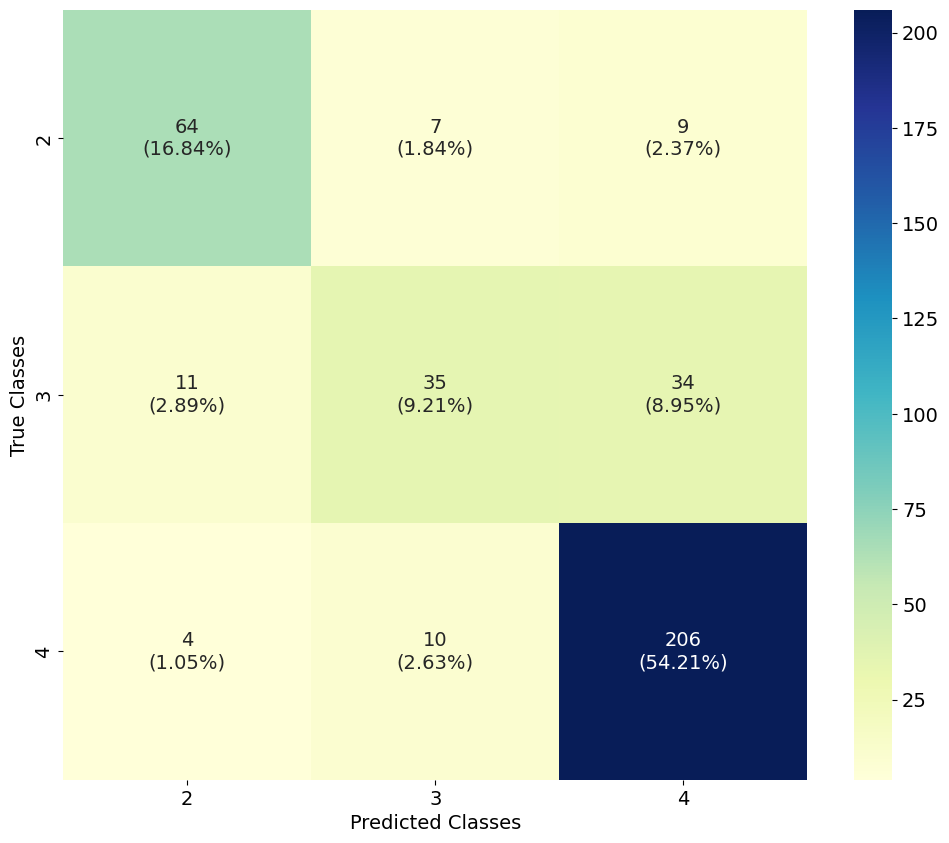

In [15]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(3, 3)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=[2,3,4], yticklabels=[2,3,4],
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()